### Sand Rate, Mixed Velocity and Erosion calculation from Pysand

__Go through the following steps :__

1. Update TAG, time range, sampling frequency in sec
2. Update R, GF and d_p input
3. Update well input data
4. Define CGR, WGR
5. Update segment name to get correct polynomials for Z.values
6. Update the class variables (D, rho, MW, mu) for the correct well input
7. Select vendor name for the step values
8. Select erosion model and material
<br> Erosion models available : bend, tee, straight_pipe, welded_joint, manifold, reducer, probes, flexible
<br> Materials available : carbon_steel, duplex, ss316, inconel, grp_epoxy, aluminium, dc_05_tungsten, etc

__How the Erosion models selected, and the required input__ :
- bend(v_m, rho_m, mu_m, R, GF, D, d_p, material='duplex', rho_p=2650)
- tee(v_m, rho_m, mu_m, GF, D, d_p, material='duplex', rho_p=2650):
- straight_pipe(v_m, D)
- welded_joint(v_m, rho_m, D, d_p, h, alpha=60, location='downstream', material='duplex')
- manifold(v_m, rho_m, mu_m, GF, D, d_p, Dm, material='duplex')
- reducer(v_m, rho_m, D1, D2, d_p, GF=2, alpha=60, material='duplex')
- probes(v_m, rho_m, D, d_p, alpha=60, material='duplex')
- flexible(v_m, rho_m, mu_m, mbr, D, d_p, material='duplex')
- choke_gallery(v_m, rho_m, mu_m, GF, D, d_p, R_c, gap, H, material='cr_37_tungsten')


For first time user :
1. Install Tagreader :
https://wiki.equinor.com/wiki/index.php/Tagreader-python

2. Install Pysand :
https://github.com/equinor/pysand/blob/master/README.md

***
MMEG

    Row Labels  15/9-E-4 AH T2
193 2022-02-22           180.0
0.9087088683868084


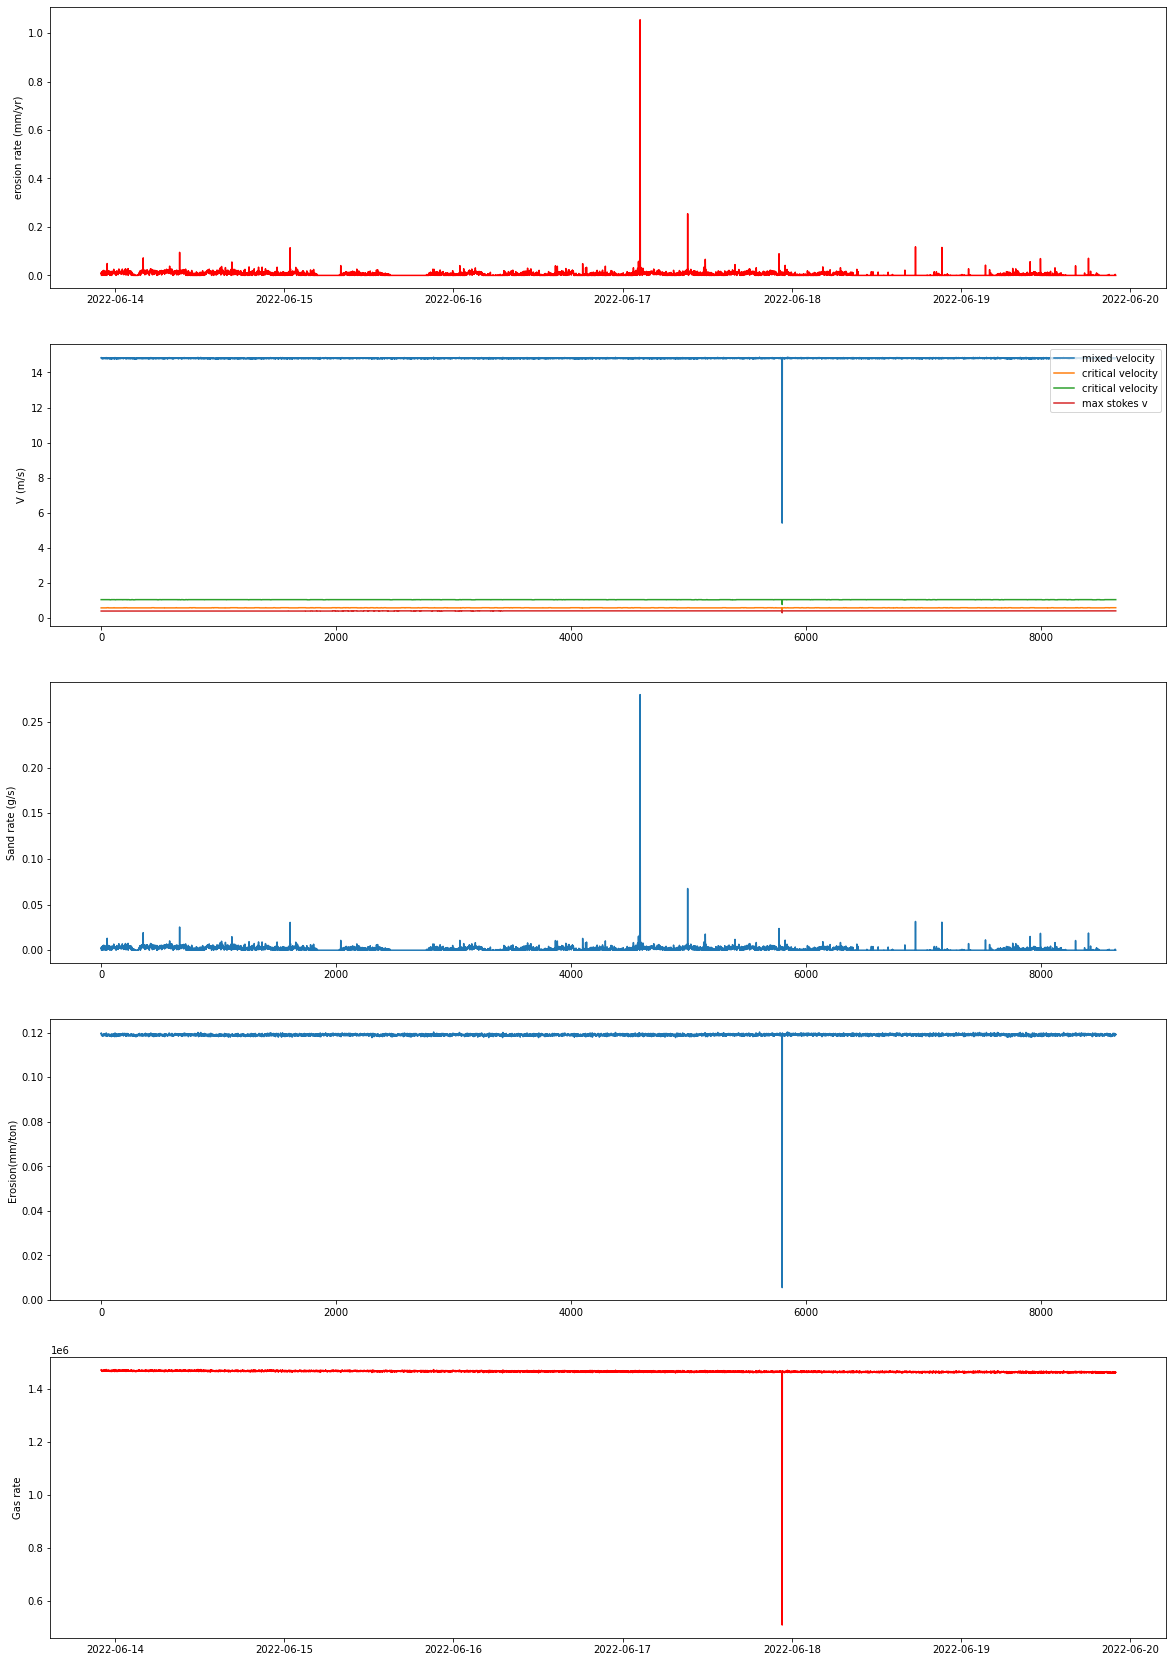

c:\appl\python3_8\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



                          time         WHP          Raw        WHT  Wing  \
0    2022-06-14 00:00:00+02:00  110.296402  4608.876953  89.512383   1.0   
1    2022-06-14 00:01:00+02:00  110.296318  4628.687988  89.512589   1.0   
2    2022-06-14 00:02:00+02:00  110.296227  4597.022949  89.512787   1.0   
3    2022-06-14 00:03:00+02:00  110.296143  4559.317383  89.512985   1.0   
4    2022-06-14 00:04:00+02:00  110.296059  4613.686035  89.513184   1.0   
...                        ...         ...          ...        ...   ...   
8635 2022-06-19 23:55:00+02:00  109.754799  4521.171875  89.506302   1.0   
8636 2022-06-19 23:56:00+02:00  109.754684  4510.179199  89.506325   1.0   
8637 2022-06-19 23:57:00+02:00  109.754570  4540.225098  89.506340   1.0   
8638 2022-06-19 23:58:00+02:00  109.754456  4528.972168  89.506363   1.0   
8639 2022-06-19 23:59:00+02:00  109.754333  4561.790527  89.506378   1.0   

            DSC  E_rate (mm/yr)  E (mm/tonn)  Qs (g/s)  Vmix (m/s)  \
0     29.729084  

In [2]:
import pysand as ps
import numpy as np
import sys
import tagreader
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime, timedelta
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly import tools


#Read data from PI. 
c=tagreader.IMSClient("SLP", "PI")
c.cache = None
c.connect()

#1. Update TAG, time range, sampling frequency in sec
#end = str(datetime.now())
#start = str(datetime.now()- timedelta(days=7))


start = datetime(2022,6,14,0,0,0)
end = datetime(2022,6,19,23,59,0)
#end = start+ timedelta(7,86100)

sampling=60
df1 = c.read(['G-18-PT___543_','G-18-AE___541A','G-18-TT___543_','G-18-XI___542_',
              'G-18-PT___545_','G-18-TT___545_'], str(start),str(end),sampling)
df1.rename(columns={'G-18-PT___543_' : 'WHP','G-18-AE___541A':'Raw','G-18-TT___543_': 'WHT',
                   'G-18-XI___542_':'Wing','G-18-PT___545_':'DSC','G-18-TT___545_':'DSCT'}, inplace=True)
# time data as column and not only index
df1=df1.reset_index()

#print(df1['WHP'])
#df1['time']=pd.to_datetime(df1['time'],format='%Y/%m/%d')
#df1['time']=df1['time'].dt.strftime('%Y/%m/%d')


n=len(df1['WHP'])
step=np.ones([n,1])
E=np.ones([n,1])
E_rate=np.ones([n,1])
Qs=np.ones([n,1])

#2. Update R, GF and d_p input

R=0.5 #bend radius, how many times ID's
GF = 3 # geometry factor
d_p = 0.25 # sand size 250 um
deg1=18 # well inclination

#3. Update well input data 
# df3 : Rates from MPFM, df2: polynomials for Z , df4:PVT tables, df5:densities, df6: background noise
#update input in df3, df6

df3=c.read(['G-18-FZ___641D','G-18-FZ___641E','G-18-FZ___642D'], str(start), str(end), sampling)
df3.rename(columns={'G-18-FZ___641D' : 'Qgas','G-18-FZ___641E':'Qoil','G-18-FZ___642D': 'Qwat'}, inplace=True)


dfP=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PRESSURES.xlsx', 
                  sheet_name='Sheet1',engine='openpyxl',skiprows=3)
dfZ=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PRESSURES.xlsx', 
                  sheet_name='AN_EAST',engine='openpyxl')

df4=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PVT.xlsx', 
                  sheet_name='PVT',index_col=0,engine='openpyxl')
df5=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PVT.xlsx', 
                  sheet_name='rho',index_col=0,engine='openpyxl')
df6=pd.read_excel('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\PVT.xlsx', 
                  sheet_name='ZERO_AN',engine='openpyxl')


MW=df5.loc['ANE']['MW_gas']
rho_w=df4.loc['E-4AH']['Water dens (kg/m3)']
rho_o=df4.loc['E-4AH']['Oil dens (kg/m3)']
mu_o=df4.loc['E-4AH']['Oil visc (kg/ms)']
mu_w=df4.loc['E-4AH']['Water visc (kg/ms)']
mu_g=df4.loc['E-4AH']['Gas Visc (kg/ms)']


# 4. Use correct well name 
dfP=dfP[['Row Labels','15/9-E-4 AH T2']]
dfP=dfP[dfP['15/9-E-4 AH T2'].notna()]

latest=dfP['Row Labels'].max()
dfP=dfP.loc[dfP['Row Labels'] >= latest]

Z=(np.interp(dfP['15/9-E-4 AH T2'],dfZ['bar'],dfZ['Z'])).mean()

print(dfP)
print(Z)




#print(CGR,WGR,zero_pol,pol)

### Define Class for the various calculations. 
#6. Update the class variables (D, rho, MW, mu) for the correct well input

class Calculate:
    D=0.1244 #pipe X-section ID
    
    
       
    def __init__(self, df_whp,df_wht, qgas,qoil,qwat,v_err,b_err,df_DSC,df_DSCT,df_wing):
       
        self.df_whp=df_whp
        self.df_wht = df_wht         
        self.qgas = qgas
        self.qoil=qoil
        self.qwat=qwat
        self.v_err=v_err
        self.b_err=b_err
        self.df_DSC=df_DSC
        self.df_DSCT=df_DSCT     
        self.wing=df_wing
        
       
    def qg(self):        
        Qg=self.qgas 
        return Qg if Qg>0  else 0
    
    def qglr(self):
        glr = self.qgas/(self.qwat+self.qoil)
        return glr 
    
            
     
    
    def v_mix(self):
        v_m = ps.fluidproperties.mix_velocity(self.df_whp, self.df_wht,self.qoil,self.qwat,self.qgas,Z,
                                              Calculate.D)
        return v_m if v_m >0 else 0
  
    
    def zerofunc(self):
        zero= np.interp(self.v_mix(),self.v_err, self.b_err)-40
        return zero if self.v_mix() >10  else 20000
    
    def rho_m(self):
        rho_m = ps.mix_density(self.df_whp, self.df_wht, self.qoil,self.qwat,self.qgas, 
                              rho_o, rho_w, MW,Z)
        return rho_m if rho_m >0 else 0.01
    
    def mu_m(self):
        mu_m = ps.fluidproperties.mix_viscosity(self.df_whp, self.df_wht,self.qoil,self.qwat, 
                                               self.qgas,mu_o, mu_w, mu_g,Z)
        return mu_m if mu_m >0 else 0.01
    
    def rho_l(self):
        rho_l=(rho_w*self.qwat+rho_o*self.qoil)/(self.qwat+self.qoil)
        return rho_l if rho_l >0 else 0.01
    
    def mu_l(self):
        mu_l=(mu_w*self.qwat+mu_o*self.qoil)/(self.qwat+self.qoil)
        return mu_l if mu_l >0 else 0.01
    
    def v_dsc(self):
        v_dsc = ps.fluidproperties.mix_velocity(self.df_DSC,self.df_DSCT,self.qoil,
                                                self.qwat,self.qgas,Z,Calculate.D)
        return v_dsc

        

### Go through the time WHP data, raw data, and calculate for the erosion

vmix_dsc=[]
zero=[]    
vmix=[]
rho_mix=[]
crit_v=[]
stoke_v1=[]
q_gas=[]
GOR=4000

#For AN, update the well name for the background noise
for i in range(0,n):
    calc = Calculate(df1['WHP'][i], df1['WHT'][i], df3['Qgas'][i]*1000,df3['Qoil'][i],
                     df3['Qwat'][i],df6['V_E4'],df6['E4'], df1['DSC'][i],df1['DSCT'][i],df1['Wing'])            
    vmix.append(calc.v_mix())
    vmix_dsc.append(calc.v_dsc())  
    zero.append(calc.zerofunc())
    q_gas.append(calc.qg())
    
    #critical velocity for moving dunes and dispersed flow
    crit_v.append(ps.transport.hydro(Calculate.D,calc.rho_l(),calc.mu_l(),d_p))
    
    #stokes velocity for the actual well inclination
    stoke_v1.append(ps.transport.stokes(calc.rho_m(),calc.mu_m(),d_p,deg1))
    
    #7. Update vendor std_step_clampon, or emerson
    step[i]=ps.asd.std_step_clampon(calc.v_mix(),GOR)
    Qs[i]=ps.asd.sand_rate(df1['Raw'][i], calc.zerofunc(), step[i])
    rho_mix.append(calc.rho_m())
    
    #8. Select erosion model and material
    #E is relative erosion in mm/ton
    E[i]=ps.erosion.bend(calc.v_mix(), calc.rho_m(), calc.mu_m(), R, GF, Calculate.D, d_p, material='carbon_steel')
    # E_rate is erosion rate in mm/yr
    E_rate[i] =ps.erosion.erosion_rate(E[i],Qs[i][0])

    #Update well name
df1['E_rate (mm/yr)']=E_rate
df1['E (mm/tonn)']=E
df1['Qs (g/s)']=Qs
df1['Vmix (m/s)']=vmix
df1['Critical vel (m/s)']=crit_v
df1['Well Name'] = "E-4AH"
df1['Background Noise'] = zero
df1['Sand lift rate']=stoke_v1
df1['Gas rates (Sm3/d)']=q_gas
df1['Mixed density']=rho_mix
df1['Vmix DSC (m/s)']=vmix_dsc

#Plot the results
rcParams['figure.figsize']=20,30
figure,axis=plt.subplots(5)    
#use.values in the date time to avoid pandas converter 
axis[0].plot(df1['time'].values,df1['E_rate (mm/yr)'].values,color='r')
axis[0].set_ylabel('erosion rate (mm/yr)')
axis[1].plot(vmix, label ='mixed velocity')
axis[1].plot(crit_v, label='critical velocity')
axis[1].plot(stoke_v1, label='max stokes v')
axis[1].set_ylabel('velocity (m/s)')
axis[1].legend(loc="upper right")
axis[1].set_ylabel('V (m/s)')
axis[2].plot(Qs)
axis[2].set_ylabel('Sand rate (g/s)')
axis[3].plot(df1['E (mm/tonn)'])
axis[3].set_ylabel('Erosion(mm/ton)')
axis[4].plot(df1['time'].values, df1['Gas rates (Sm3/d)'], color='r')
axis[4].set_ylabel('Gas rate')

#print(E)
#print(Qs)
#print(crit_v)
plt.show()



df1=df1.loc[:, ~df1.columns.isin(['DSCT'])]
df1['SR hourly_avg']=df1['Qs (g/s)'].rolling(window=60).mean()
df1['SR daily_avg']=df1['Qs (g/s)'].rolling(window=1440).mean()

##plotly
trace1=go.Scatter(x=df1['time'],y=zero,
                 mode='lines',name='Zero')

trace2=go.Scatter(x=df1['time'],y=df1['Raw'],
                 mode='lines+markers',name='Raw')


trace3=go.Scatter(x=df1['time'],y=df1['Qs (g/s)'].rolling(window=60).mean(),
                 mode='lines',name='Hourly AVG')

trace4=go.Scatter(x=df1['time'],y=df1['Qs (g/s)'].rolling(window=1440).mean(),
                 mode='lines',name='Daily AVG')

trace5=go.Scatter(x=df1['time'],y=df1['Qs (g/s)'],
                 mode='lines',name='Sand Rates')



fig=tools.make_subplots(rows=2,cols=1,subplot_titles=['ASD','Sand Rates '])
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.append_trace(trace3,2,1)
fig.append_trace(trace4,2,1)
fig.append_trace(trace5,2,1)

fig['layout'].update(title='E-4AH')

pyo.plot(fig)

print(df1)

#append results to csv file, mode a (append)
df1.to_csv('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\sand\\E4H.csv', mode='a',index=False, header=None)
#df1.to_csv('G:\\UPN\\T-S_Sleipner\\PETEK_B&B_RESU\\Protek\\Megawati\\sand\\E4H.csv', index=False, header=True)
